In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
import data_generator as dg

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

\[
\begin{align*}
\text{Maximise:} & \quad Z = c_1x_1 + c_2x_2 + \cdots + c_nx_n \quad \text{(Objective function)} \\
\text{Subject to:} & \quad x_1 + x_2 + \cdots + x_n = 50 \quad \text{(Total budget constraint)} \\
                  & \quad 5 \leq x_i \leq 15 \quad \text{for } i = 1, 2, \ldots, n \quad \text{(Channel-level constraints)} \\
\end{align*}
\]


# 0) MMM data generator

In [3]:
np.random.seed(10)

# Set parameters for data generator
start_date = "2021-01-01"
periods = 52 * 3
channels = ["tv", "social", "search"]
adstock_alphas = [0.50, 0.25, 0.05]
saturation_lamdas = [1.5, 2.5, 3.5]
betas = [350, 150, 50]
spend_scalars = [10, 15, 20]

df = dg.data_generator(start_date, periods, channels, spend_scalars, adstock_alphas, saturation_lamdas, betas)

# Scale betas using maximum sales value - this is so it is comparable to the fitted beta from pymc (pymc does feature and target scaling using MaxAbsScaler from sklearn)
betas_scaled = [
    ((df["tv_sales"] / df["sales"].max()) / df["tv_saturated"]).mean(),
    ((df["social_sales"] / df["sales"].max()) / df["social_saturated"]).mean(),
    ((df["search_sales"] / df["sales"].max()) / df["search_saturated"]).mean()
]

# Calculate contributions
contributions = np.asarray([
    round((df["tv_sales"].sum() / df["sales"].sum()), 2),
    round((df["social_sales"].sum() / df["sales"].sum()), 2),
    round((df["search_sales"].sum() / df["sales"].sum()), 2),
    round((df["demand"].sum() / df["sales"].sum()), 2)
])

df[["date", "demand", "demand_proxy", "tv_spend_raw", "social_spend_raw", "search_spend_raw", "sales"]]

,date,demand,demand_proxy,tv_spend_raw,social_spend_raw,search_spend_raw,sales
0,2021-01-03,356.003195,330.831226,5501.441206,5894.908137,7182.864568,489.566208
1,2021-01-10,301.006385,317.461345,2507.942445,5791.555554,6312.367780,441.138691
2,2021-01-17,81.538923,89.223970,1049.661462,1081.642708,1429.740857,152.309451
3,2021-01-24,241.765941,169.729439,3008.937195,5323.913163,6185.584938,367.160745
4,2021-01-31,311.145259,349.047382,3171.490614,6830.642777,7227.783598,465.083840
...,...,...,...,...,...,...,...
151,2023-11-26,504.966471,517.052302,4065.830904,10716.104909,9975.069784,743.618076
152,2023-12-03,604.005118,633.299525,3740.575561,7287.215373,16792.317339,822.314394
153,2023-12-10,525.265482,438.144702,6442.185846,11242.173092,6893.282177,763.558935
154,2023-12-17,458.850104,581.817816,4555.589865,3870.492537,6558.943829,646.468794


# 2) Training model

In [4]:
# set date column
date_col = "date"

# set outcome column
y_col = "sales"

# set marketing variables
channel_cols = ["tv_spend_raw",
                "social_spend_raw",
                "search_spend_raw"]

# set control variables
control_cols = ["demand"]

# create arrays
X = df[[date_col] + channel_cols + control_cols]
y = df[y_col]

# set test (out-of-sample) length
test_len = 8

# create train and test indexs
train_idx = slice(0, len(df) - test_len)
out_of_time_idx = slice(len(df) - test_len, len(df))

In [5]:
mmm_default = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
)

mmm_default.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [6]:
fit_kwargs = {
    "tune": 1_000,
    "chains": 4,
    "draws": 1_000,
    "target_accept": 0.9,
}

mmm_default.fit(X[train_idx], y[train_idx], **fit_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 202 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

# 3) Validating model

In [7]:
channels = np.array(["tv", "social", "search", "demand"])

true_contributions = pd.DataFrame({'Channels': channels, 'Contributions': contributions})
true_contributions= true_contributions.sort_values(by='Contributions', ascending=False).reset_index(drop=True)
true_contributions = true_contributions.style.bar(subset=['Contributions'], color='lightblue')

true_contributions

,Channels,Contributions
0,demand,0.700000
1,tv,0.140000
2,social,0.110000
3,search,0.050000


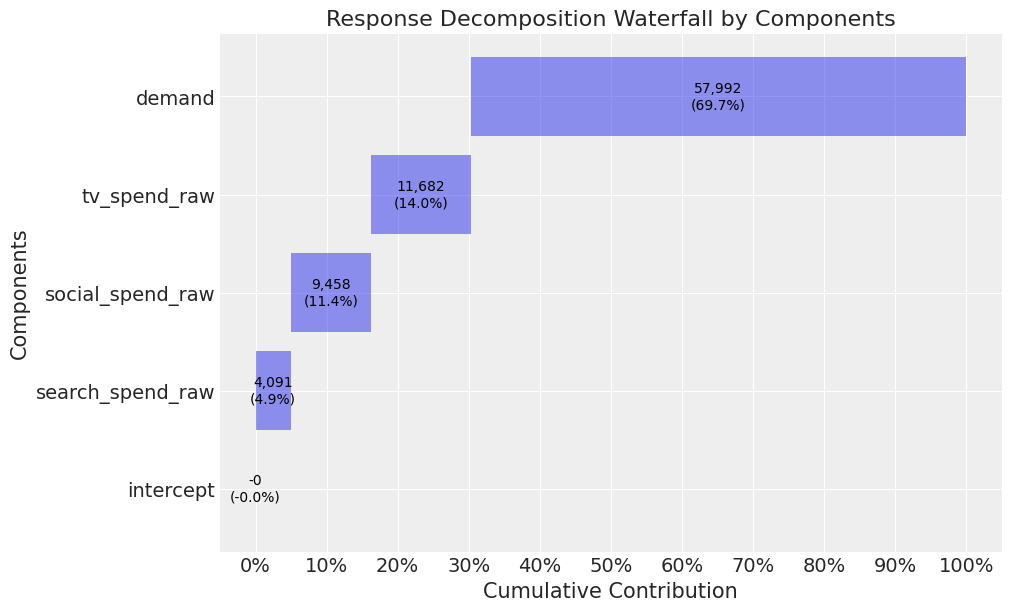

In [8]:
mmm_default.plot_waterfall_components_decomposition(figsize=(10,6));

# 4) Response curves

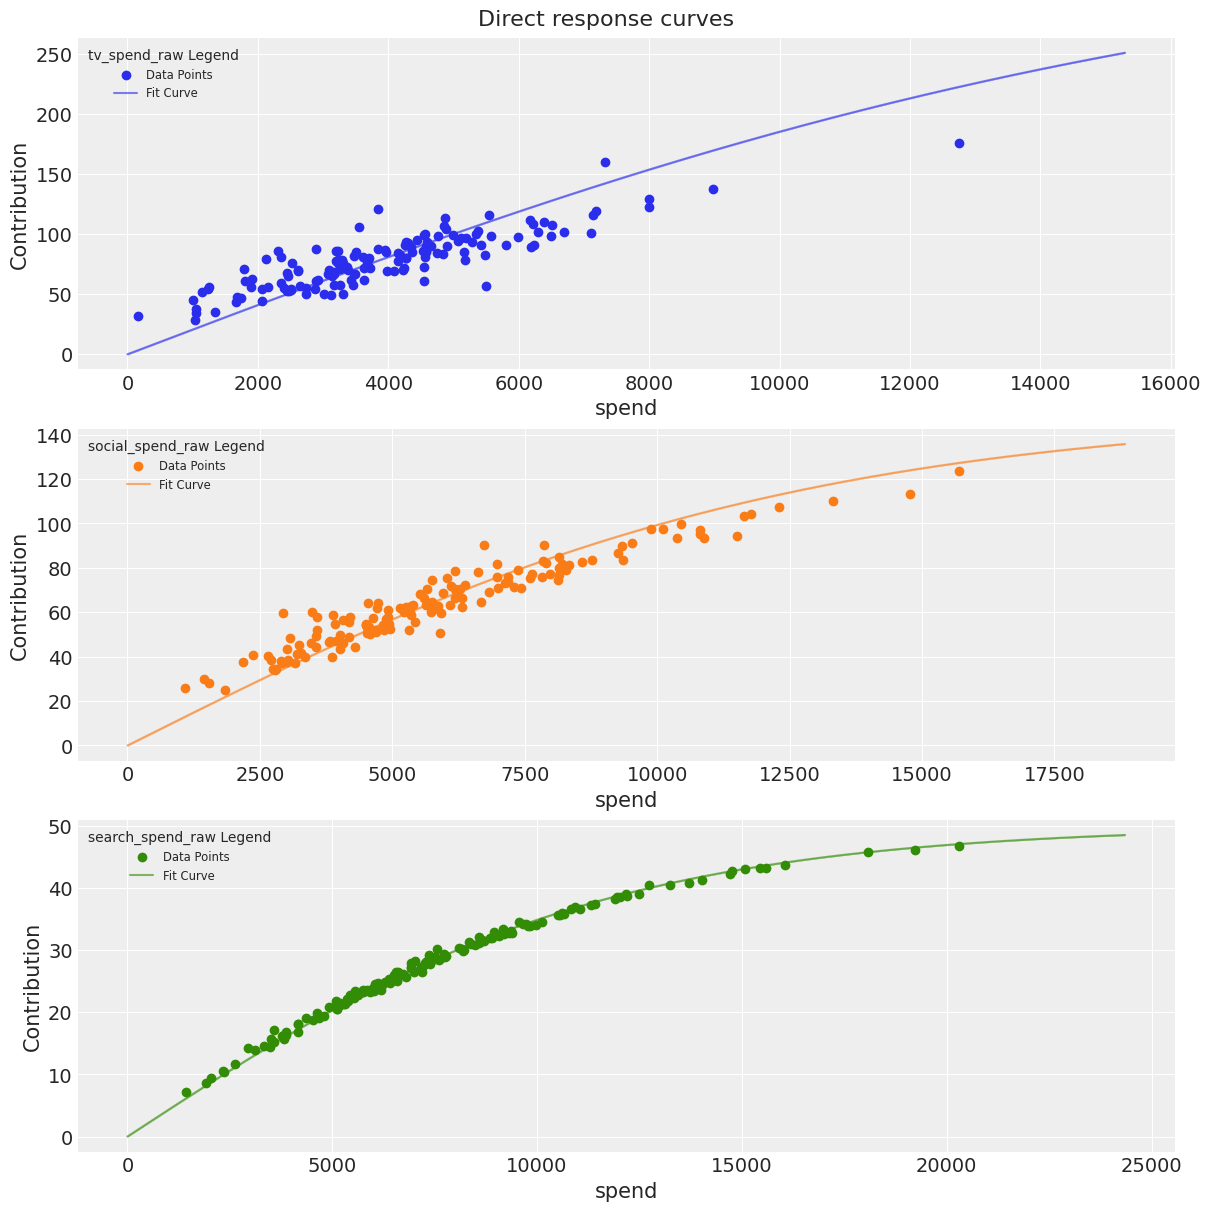

In [9]:
fig = mmm_default.plot_direct_contribution_curves(show_fit=True, xlim_max=1.2)
[ax.set(xlabel="spend") for ax in fig.axes];

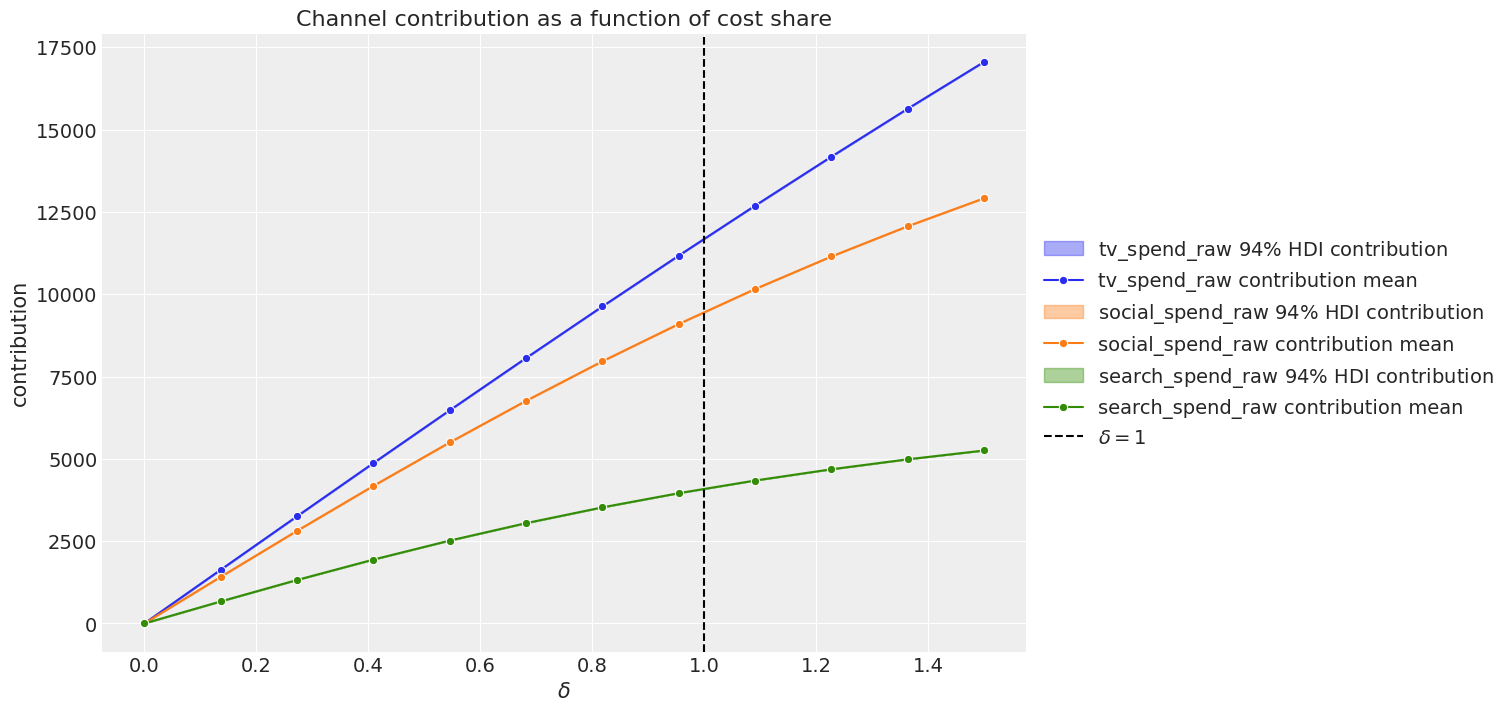

In [10]:
mmm_default.plot_channel_contributions_grid(start=0, stop=1.5, num=12, figsize=(15, 7));

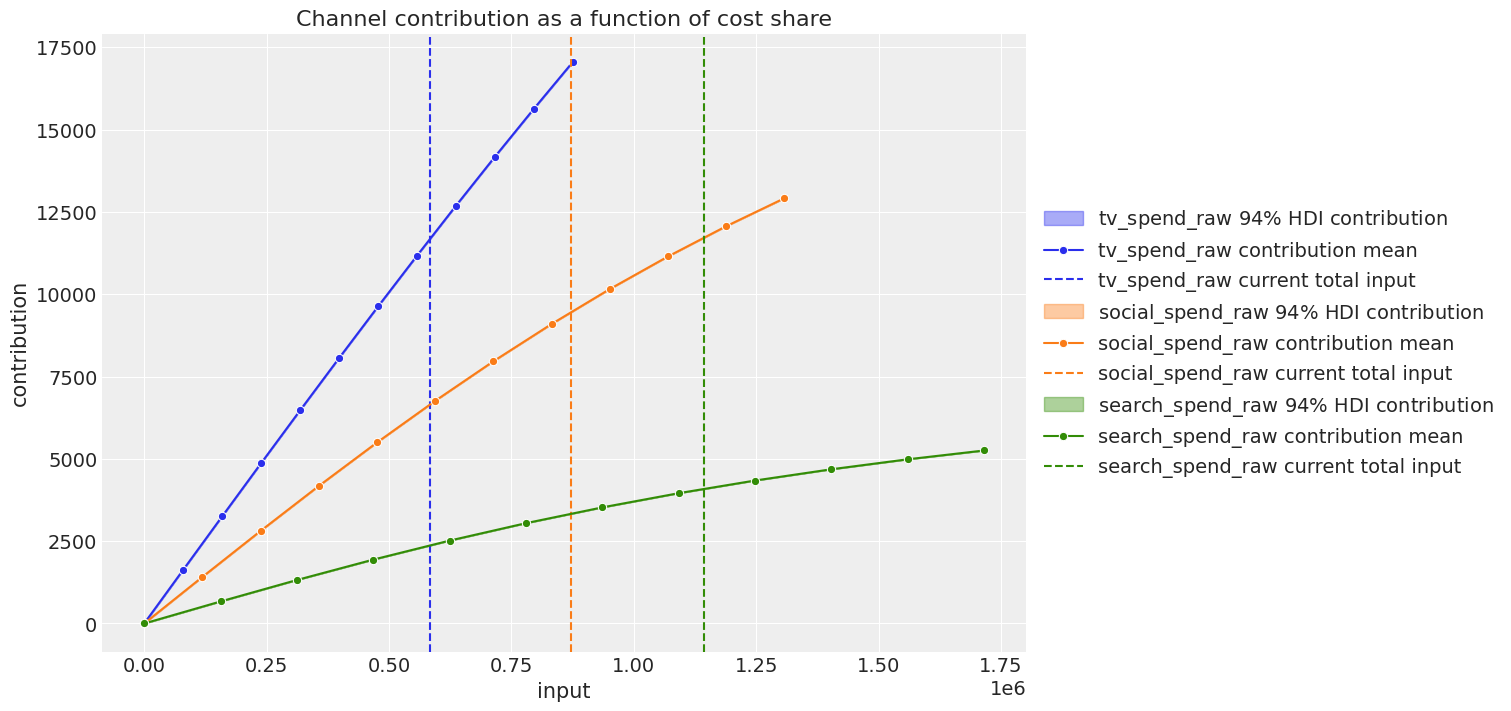

In [11]:
mmm_default.plot_channel_contributions_grid(start=0, stop=1.5, num=12, absolute_xrange=True, figsize=(15, 7));

# 5) Optimising budgets

In [12]:
perc_change = 0.20
budget_len = 12
budget_idx = slice(len(df) - test_len, len(df))
recent_period = X[budget_idx][channel_cols]

recent_period

,tv_spend_raw,social_spend_raw,search_spend_raw
148,4223.983706,6887.972160,8829.905418
149,5242.930341,13159.274324,18088.903771
150,7423.276609,9763.455538,7451.072463
151,4065.830904,10716.104909,9975.069784
152,3740.575561,7287.215373,16792.317339
153,6442.185846,11242.173092,6893.282177
154,4555.589865,3870.492537,6558.943829
155,2637.616935,8490.789891,6587.909768


In [46]:
# set overall budget constraint (to the nearest £1k)
budget = round(recent_period.sum(axis=0).sum() / budget_len, -3)

# record the current budget split by channel
current_budget_split = round(recent_period.mean() / recent_period.mean().sum(), 2)

# set channel level constraints
lower_bounds = round(recent_period.min(axis=0) * (1 - perc_change))
upper_bounds = round(recent_period.max(axis=0) * (1 + perc_change))

budget_bounds = {
    channel: [lower_bounds[channel], upper_bounds[channel]]
    for channel in channel_cols
}

print(f'Overall budget constraint: {budget}')
print('Channel constraints:')
for channel, bounds in budget_bounds.items():
    print(f'  {channel}: Lower Bound = {bounds[0]}, Upper Bound = {bounds[1]}')

Overall budget constraint: 16000.0
Channel constraints:
  tv_spend_raw: Lower Bound = 2110.0, Upper Bound = 8908.0
  social_spend_raw: Lower Bound = 3096.0, Upper Bound = 15791.0
  search_spend_raw: Lower Bound = 5247.0, Upper Bound = 21707.0


In [47]:
model_granularity = "weekly"

allocation_strategy, optimization_result = mmm_default.optimize_budget(
    budget=budget,
    num_periods=budget_len,
    budget_bounds=budget_bounds,
    minimize_kwargs={
        "method": "SLSQP",
        "options": {"ftol": 1e-9, "maxiter": 5_000},
    },
)

response = mmm_default.sample_response_distribution(
    allocation_strategy=allocation_strategy,
    time_granularity=model_granularity,
    num_periods=budget_len,
    noise_level=0.05,
)

/Users/ryanosullivan/Documents/repos/pymc_marketing/venv/lib/python3.12/site-packages/pymc_marketing/mmm/budget_optimizer.py:202: UserWarning: Using default equality constraint
  self.set_constraints(


In [48]:
opt_spend = pd.Series(allocation_strategy, index=recent_period.mean().index).to_frame(name="opt_spend")
opt_spend["avg_spend"] = budget * current_budget_split
opt_spend

,opt_spend,avg_spend
tv_spend_raw,7657.0,3200.0
social_spend_raw,3096.0,5920.0
search_spend_raw,5247.0,6880.0


In [49]:
opt_spend.sum()

opt_spend    16000.0
avg_spend    16000.0
dtype: float64

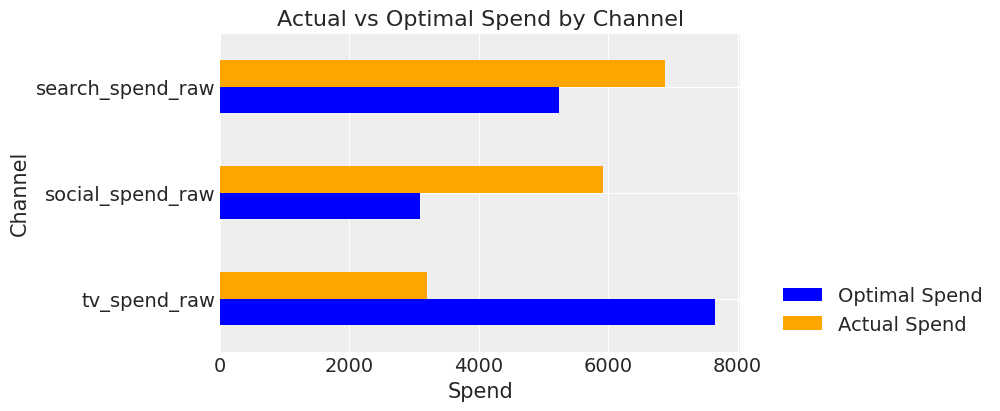

In [54]:
fig, ax = plt.subplots(figsize=(9, 4))
opt_spend.plot(kind='barh', ax=ax, color=['blue', 'orange'])

plt.xlabel("Spend")
plt.ylabel("Channel")
plt.title("Actual vs Optimal Spend by Channel")
plt.legend(["Optimal Spend", "Actual Spend"])
plt.legend(["Optimal Spend", "Actual Spend"], loc='lower right', bbox_to_anchor=(1.5, 0.0))

plt.show()

In [64]:
# create dataframe with optimal spend
last_date = mmm_default.X["date"].max()
new_dates = pd.date_range(start=last_date, periods=1 + budget_len, freq="W-MON")[1:]
budget_scenario_opt = pd.DataFrame({"date": new_dates,})
budget_scenario_opt["tv_spend_raw"] = opt_spend["opt_spend"]["tv_spend_raw"]
budget_scenario_opt["social_spend_raw"] = opt_spend["opt_spend"]["social_spend_raw"]
budget_scenario_opt["search_spend_raw"] = opt_spend["opt_spend"]["search_spend_raw"]
budget_scenario_opt["demand"] = X[budget_idx][control_cols].mean()[0]

# calculate overall contribution
scenario_contrib_opt = mmm_default.sample_posterior_predictive(
    X_pred=budget_scenario_opt, extend_idata=False
)

opt_contrib = scenario_contrib_opt.mean(dim="sample").sum()["y"].values

Output()

In [65]:
# create dataframe with avg spend
last_date = mmm_default.X["date"].max()
new_dates = pd.date_range(start=last_date, periods=1 + budget_len, freq="W-MON")[1:]
budget_scenario_avg = pd.DataFrame({"date": new_dates,})
budget_scenario_avg["tv_spend_raw"] = opt_spend["avg_spend"]["tv_spend_raw"]
budget_scenario_avg["social_spend_raw"] = opt_spend["avg_spend"]["social_spend_raw"]
budget_scenario_avg["search_spend_raw"] = opt_spend["avg_spend"]["search_spend_raw"]
budget_scenario_avg["demand"] = X[budget_idx][control_cols].mean()[0]

# calculate overall contribution
scenario_contrib_avg  = mmm_default.sample_posterior_predictive(
    X_pred=budget_scenario_avg , extend_idata=False
)

avg_contrib = scenario_contrib_avg.mean(dim="sample").sum()["y"].values

Output()

In [75]:
print(f'% increase in sales: {round((opt_contrib / avg_contrib) - 1, 2)}')

% increase in sales: 0.06
